In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces'
od.download(dataset_url)

In [3]:
train_dir="archive/dataset/train"
test_dir="archive/dataset/test"

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(train_dir)

There are 2 directories and 0 images in 'archive/dataset/train'.
There are 0 directories and 197826 images in 'archive/dataset/train/real'.
There are 0 directories and 155000 images in 'archive/dataset/train/fake'.


In [6]:
import os
from pathlib import Path

# Define the train directory as a Path object
data_dir = Path(train_dir)


# Walk through the valid directory
walk_through_dir(data_dir)

import random
from PIL import Image

# Set seed
random.seed(12) # <- try changing this and see what happens

import random

# Get all image paths
image_path_list = list(data_dir.glob("**/*.jpg"))
# Get a random index
random_index = random.randint(0, len(image_path_list) - 1)
# Get the image at the random index
random_image_path = image_path_list[random_index]

# 4. Open image
img = Image.open(random_image_path)


There are 2 directories and 0 images in 'archive/dataset/train'.
There are 0 directories and 197826 images in 'archive/dataset/train/real'.
There are 0 directories and 155000 images in 'archive/dataset/train/fake'.


archive/dataset/train/fake/8H5J5AMCFX_resized.jpg


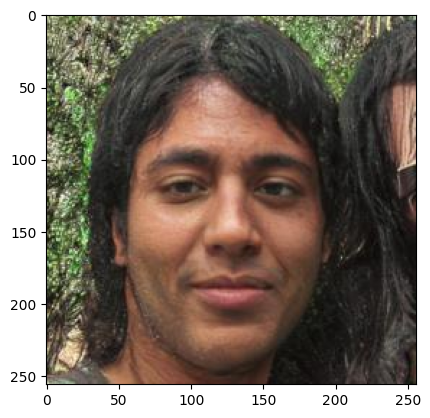

In [10]:
print(random_image_path)
plt.imshow(img)

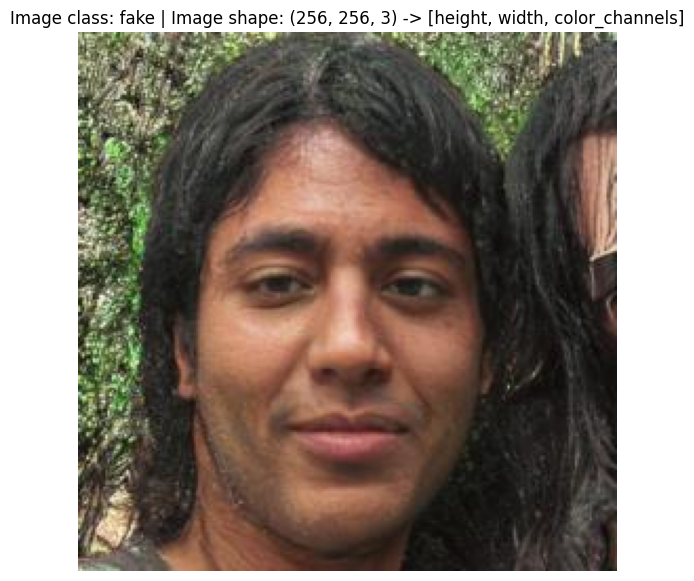

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
image_class = random_image_path.parent.stem

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [12]:
weights=torchvision.models.ResNet50_Weights.DEFAULT
weights

ResNet50_Weights.IMAGENET1K_V2

In [13]:
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(test_dir,
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 352826
    Root location: archive/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 76713
    Root location: archive/dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [15]:
class_names = train_data.classes
class_names

['fake', 'real']

In [65]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x787155724220>,
 <torch.utils.data.dataloader.DataLoader at 0x7871557271c0>)

In [66]:
weights=torchvision.models.ResNet50_Weights.DEFAULT
model=torchvision.models.resnet50(weights=weights).to(device)

In [67]:
# !pip install -q torchinfo
from torchinfo import summary

In [68]:
summary(model,
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [69]:
for param in model.parameters():
    param.requires_grad = False

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.fc= torch.nn.Sequential(
    torch.nn.Linear(2048,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=output_shape,
                    bias=True)
    ).to(device)

In [71]:
summary(model,
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [72]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for (X, y) in tqdm(dataloader, desc="Batch"):
        # Send data to target device
        # print("\rbatch: " + str(batch) + "/" + str(round(int(100000/64))), end = "")
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [73]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [74]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print("Epoch:",epoch + 1)
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [75]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Train model_0
results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1


Batch: 100%|██████████| 11026/11026 [38:04<00:00,  4.83it/s]


Epoch: 1 | train_loss: 0.1366 | train_acc: 0.9444 | test_loss: 0.1000 | test_acc: 0.9598
Epoch: 2


Batch: 100%|██████████| 11026/11026 [36:19<00:00,  5.06it/s]


Epoch: 2 | train_loss: 0.0955 | train_acc: 0.9626 | test_loss: 0.0857 | test_acc: 0.9669
Epoch: 3


Batch: 100%|██████████| 11026/11026 [36:15<00:00,  5.07it/s]


Epoch: 3 | train_loss: 0.0823 | train_acc: 0.9686 | test_loss: 0.0849 | test_acc: 0.9686
Epoch: 4


Batch: 100%|██████████| 11026/11026 [33:09<00:00,  5.54it/s]


Epoch: 4 | train_loss: 0.0737 | train_acc: 0.9721 | test_loss: 0.0845 | test_acc: 0.9704
Epoch: 5


Batch: 100%|██████████| 11026/11026 [33:08<00:00,  5.54it/s]


Epoch: 5 | train_loss: 0.0670 | train_acc: 0.9749 | test_loss: 0.0787 | test_acc: 0.9700
Epoch: 6


Batch: 100%|██████████| 11026/11026 [33:08<00:00,  5.54it/s]


Epoch: 6 | train_loss: 0.0619 | train_acc: 0.9769 | test_loss: 0.0961 | test_acc: 0.9713
Epoch: 7


Batch: 100%|██████████| 11026/11026 [33:08<00:00,  5.54it/s]


Epoch: 7 | train_loss: 0.0571 | train_acc: 0.9788 | test_loss: 0.0824 | test_acc: 0.9698
Epoch: 8


Batch: 100%|██████████| 11026/11026 [33:08<00:00,  5.54it/s]


Epoch: 8 | train_loss: 0.0543 | train_acc: 0.9802 | test_loss: 0.0921 | test_acc: 0.9727
Epoch: 9


Batch: 100%|██████████| 11026/11026 [33:08<00:00,  5.55it/s]


Epoch: 9 | train_loss: 0.0519 | train_acc: 0.9811 | test_loss: 0.0759 | test_acc: 0.9717
Epoch: 10


Batch: 100%|██████████| 11026/11026 [33:07<00:00,  5.55it/s]


Epoch: 10 | train_loss: 0.0501 | train_acc: 0.9819 | test_loss: 0.0884 | test_acc: 0.9722
Total training time: 24721.118 seconds


In [76]:
import typing
from typing import Dict, List

In [77]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

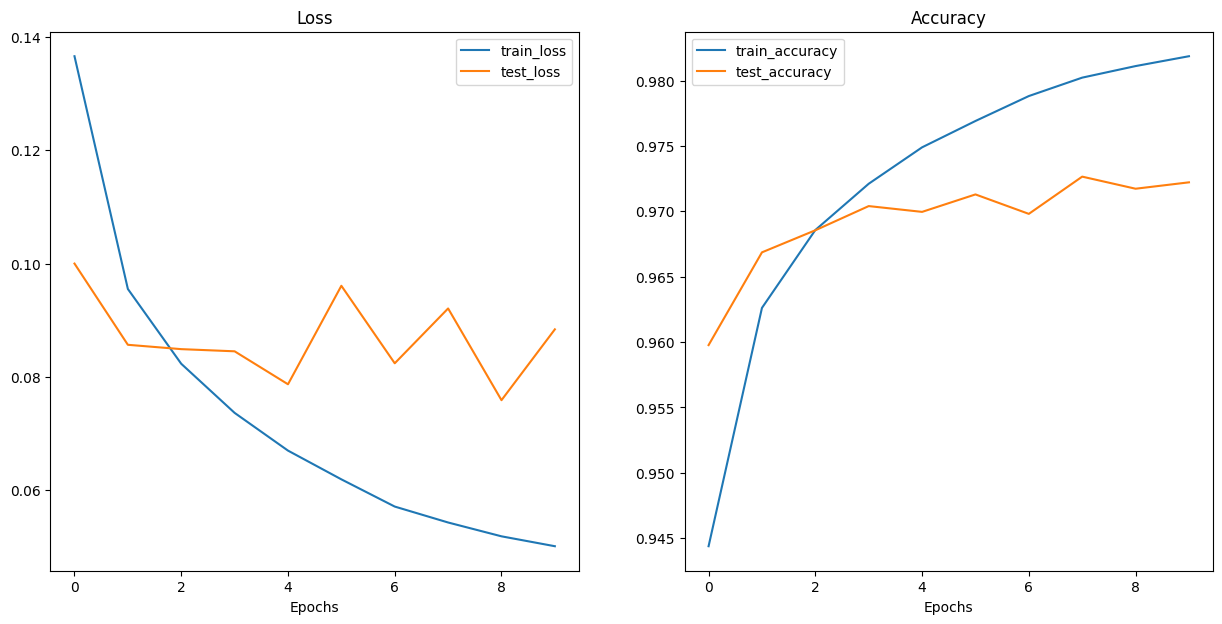

In [78]:
plot_loss_curves(results)

In [80]:
custom_image_path='examples/02864.jpg'

In [81]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[135, 129, 128,  ...,  40,  39,  42],
         [128, 122, 125,  ...,  37,  35,  38],
         [123, 124, 124,  ...,  35,  35,  38],
         ...,
         [ 83,  94,  52,  ..., 118,  52,  30],
         [ 63,  83,  51,  ..., 171, 124,  52],
         [ 68,  53,  51,  ..., 188, 170,  89]],

        [[127, 121, 123,  ...,  61,  65,  70],
         [124, 118, 122,  ...,  56,  59,  65],
         [126, 127, 125,  ...,  50,  52,  58],
         ...,
         [109, 120,  78,  ...,  86,  40,  30],
         [ 89, 109,  77,  ..., 123,  96,  34],
         [ 94,  79,  77,  ..., 132, 133,  61]],

        [[125, 119, 119,  ...,  28,  26,  29],
         [121, 115, 117,  ...,  24,  23,  24],
         [119, 120, 119,  ...,  21,  20,  21],
         ...,
         [132, 143, 101,  ...,  87,  24,   4],
         [114, 134, 102,  ..., 139,  95,  24],
         [119, 104, 102,  ..., 157, 140,  58]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 256, 256])

Custom image dataty

In [82]:
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image=custom_image/255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.5294, 0.5059, 0.5020,  ..., 0.1569, 0.1529, 0.1647],
         [0.5020, 0.4784, 0.4902,  ..., 0.1451, 0.1373, 0.1490],
         [0.4824, 0.4863, 0.4863,  ..., 0.1373, 0.1373, 0.1490],
         ...,
         [0.3255, 0.3686, 0.2039,  ..., 0.4627, 0.2039, 0.1176],
         [0.2471, 0.3255, 0.2000,  ..., 0.6706, 0.4863, 0.2039],
         [0.2667, 0.2078, 0.2000,  ..., 0.7373, 0.6667, 0.3490]],

        [[0.4980, 0.4745, 0.4824,  ..., 0.2392, 0.2549, 0.2745],
         [0.4863, 0.4627, 0.4784,  ..., 0.2196, 0.2314, 0.2549],
         [0.4941, 0.4980, 0.4902,  ..., 0.1961, 0.2039, 0.2275],
         ...,
         [0.4275, 0.4706, 0.3059,  ..., 0.3373, 0.1569, 0.1176],
         [0.3490, 0.4275, 0.3020,  ..., 0.4824, 0.3765, 0.1333],
         [0.3686, 0.3098, 0.3020,  ..., 0.5176, 0.5216, 0.2392]],

        [[0.4902, 0.4667, 0.4667,  ..., 0.1098, 0.1020, 0.1137],
         [0.4745, 0.4510, 0.4588,  ..., 0.0941, 0.0902, 0.0941],
         [0.4667, 0.4706, 0.4667,  ..

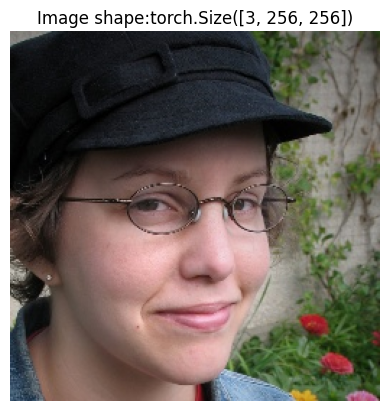

In [83]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape:{custom_image.shape}")
plt.axis(False);

In [84]:
custom_image_transform=transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed=custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 256, 256])
New shape: torch.Size([3, 64, 64])


In [86]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

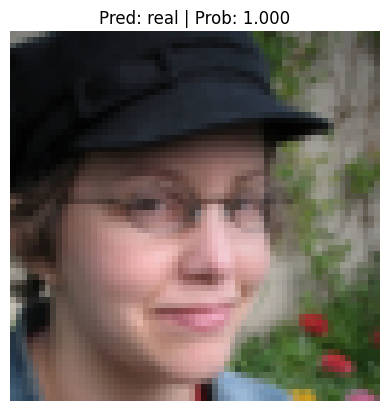

In [87]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [88]:
img='/content/images (3).jpeg'

In [89]:
pred_and_plot_image(model=model,
                    image_path=img,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

RuntimeError: [Errno 2] No such file or directory: '/content/images (3).jpeg'

In [ ]:
vk='/content/Virat_Kohli_during_the_India_vs_Aus_4th_Test_match_at_Narendra_Modi_Stadium_on_09_March_2023.jpg'

In [90]:
pred_and_plot_image(model=model,
                    image_path=vk,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

NameError: name 'vk' is not defined

In [91]:
val='/content/real_00015.jpg'

In [92]:
pred_and_plot_image(model=model,
                    image_path=val,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)


RuntimeError: [Errno 2] No such file or directory: '/content/real_00015.jpg'

In [ ]:
modi='/content/Modi_tendering_his_resignation_to_the_President_(cropped).jpg'

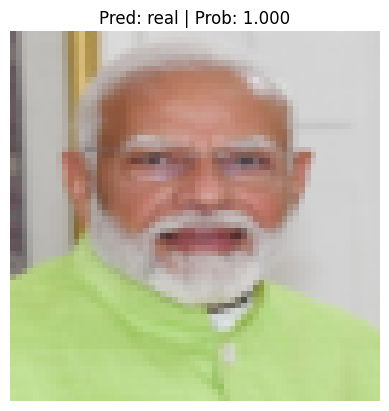

In [ ]:
pred_and_plot_image(model=model,
                    image_path=modi,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
ai='/content/1_vW234iL2w0KbhNdMuc0O1w.jpg'

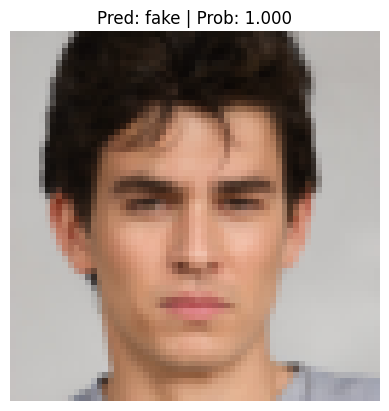

In [ ]:
pred_and_plot_image(model=model,
                    image_path=ai,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
ai2="/content/ai-generated-portrait-of-a-young-man-no-facial-expression-facing-the-camera-isolated-white-background-ai-generative-photo.jpg"

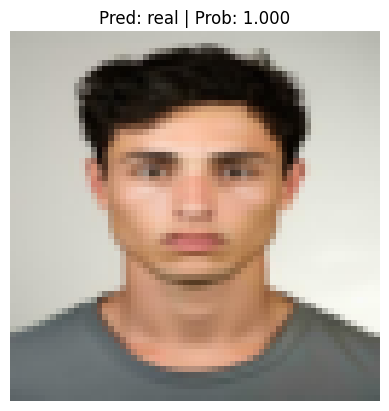

In [ ]:
pred_and_plot_image(model=model,
                    image_path=ai2,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
dw="/content/download.jpeg"

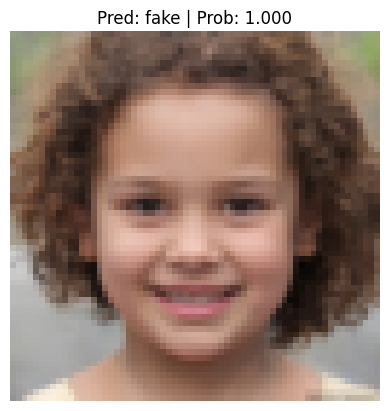

In [ ]:
pred_and_plot_image(model=model,
                    image_path=dw,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
dn="/content/download (1).jpeg"

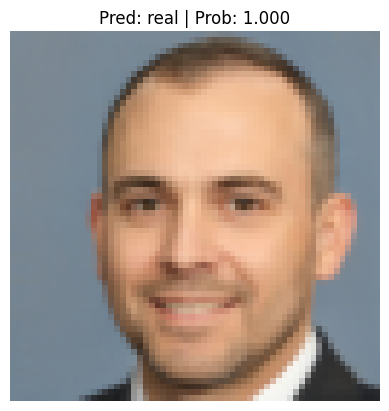

In [ ]:
pred_and_plot_image(model=model,
                    image_path=dn,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
di="/content/download (2).jpeg"

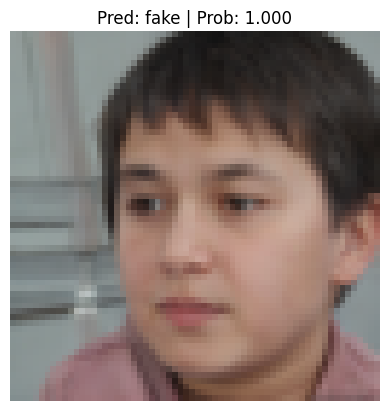

In [ ]:
pred_and_plot_image(model=model,
                    image_path=di,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a1="/content/download (3).jpeg"

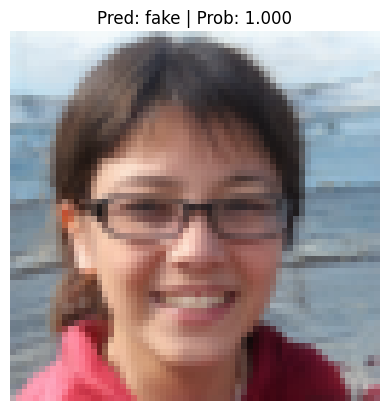

In [ ]:
pred_and_plot_image(model=model,
                    image_path=a1,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a2="/content/download (4).jpeg"

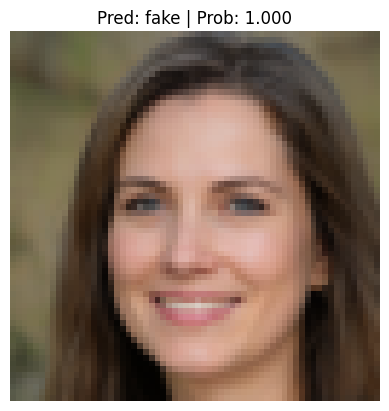

In [ ]:
pred_and_plot_image(model=model,
                    image_path=a2,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
mamu="/content/Mamu.jpg"

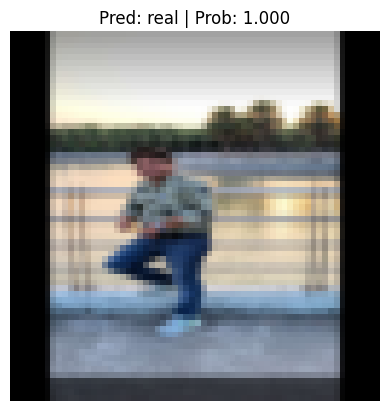

In [ ]:
pred_and_plot_image(model=model,
                    image_path=mamu,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a3="/content/download (5).jpeg"

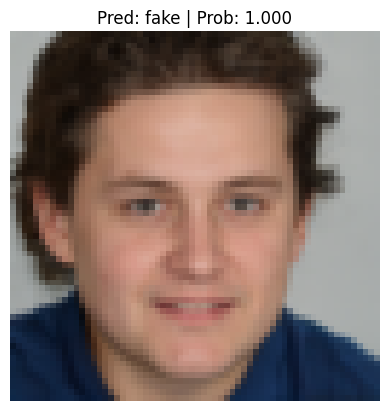

In [ ]:
pred_and_plot_image(model=model,
                    image_path=a3,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
try:
  import gradio as gd
except:
  !pip install gradio
  import gradio as gr

print(f"Gradio version:{gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.5 MB/

In [ ]:
model.to('cpu')

next(iter(model.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = auto_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
test_dir='/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/CYMWHHQUYO.jpg

Prediction label and probability dictionary: 
{'fake': 0.9999924898147583, 'real': 7.5066977842652705e-06}
Prediction time: 0.33528 seconds


In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/CSFEIYUG1J.jpg'],
 ['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/15266.jpg'],
 ['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/OS20LOPU8W.jpg']]

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Real Or Fake"
description = "A computer vision model to classify images of as Real Or Fake (Generated By Ai)"
article = "Created at [Flower Classification]."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1350620282c6a6d48e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import shutil
from pathlib import Path

real_or_fake_demo_path=Path('demos/real_or_fake')

if real_or_fake_demo_path.exists():
  shutil.rmtree(real_or_fake_demo_path)
  real_or_fake_demo_path.mkdir(parents=True,
                                        exist_ok=True)
else:
  real_or_fake_demo_path.mkdir(parents=True,
                                        exist_ok=True)


!ls demos/real_or_fake/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
real_or_fake_examples_path = real_or_fake_demo_path / "examples"
real_or_fake_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
real_or_fake_examples = [Path('/content/Images/val/rose/8524505682_bda885af3a_n.jpg'),
                            Path('/content/Images/val/daisy/754296579_30a9ae018c_n.jpg'),
                            Path('/content/Images/val/tulip/20435554843_ba6862f923_n.jpg')]

# 3. Copy the three random images to the examples directory
for example in real_or_fake_examples:
    destination = real_or_fake_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying /content/Images/val/rose/8524505682_bda885af3a_n.jpg to demos/real_or_fake/examples/8524505682_bda885af3a_n.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/content/Images/val/rose/8524505682_bda885af3a_n.jpg'

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(real_or_fake_examples_path)]
example_list


In [ ]:
from pathlib import Path

Model_Path=Path("Models")
Model_Path.mkdir(parents=True,
                 exist_ok=True)

Model_Name="RealityCheck.pth"
Model_Save_Path=Model_Path/Model_Name

print(f"Saving Model to : {Model_Save_Path}")
torch.save(obj=model.state_dict(),
           f=Model_Save_Path)

Saving Model to : Models/RealityCheck.pth


In [ ]:
import shutil

# Create a source path for our target model
model_real_or_fake_model_path = "models/RealityCheck.pth"

# Create a destination path for our target model
model_real_or_fake_model_destination = real_or_fake_demo_path / model_real_or_fake_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_real_or_fake_model_path} to {model_real_or_fake_model_destination}")

    # Move the model
    shutil.move(src=model_real_or_fake_model_path,
                dst=model_real_or_fake_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {model_real_or_fake_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {model_real_or_fake_model_destination}: {model_real_or_fake_model_destination.exists()}")

In [ ]:
class_names=train_data.classes
class_names

In [ ]:
%%writefile demos/real_or_fake/model.py

import torch
import torchvision
from torch import nn

def create_model(num_classes:int=2,
                 seed:int=42):
  weights=torchvision.models.ResNet50_Weights.DEFAULT
  transforms=weights.transforms
  model=torchvision.models.resnet50(weights=weights)

  for param in model.parameters():
    param.requires_grad=False

  torch.manual_seed(42)
  model.fc= torch.nn.Sequential(
    torch.nn.Linear(2048,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=output_shape,
                    bias=True)

    )

  return model,transforms



In [ ]:
%%writefile demos/real_or_fake/app.py

import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['Real', 'Fake']

### 2. Model and transforms preparation ###

# Create model
model, model_transforms = create_model(
    num_classes=2,
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="RealityCheck.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = model_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Reality Check"
description = "An computer vision model to classify images as Real Or Fake(Ai Generated). The Model can classify the images with 95% Accuracy"
article = "Created at [Real Or Fake]"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

In [ ]:
%%writefile demos/flower_classification/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio==4.32.2

In [ ]:
!ls demos/real_or_fake

In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/real_or_fake && zip -r ../real_or_fake.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/real_or_fake.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")